# Quantum computing code draft for SQL grammar to circuit

## Parsing

Parse the SQL queries from the examples folder. The queries are parsed with ANTRL framework which is extensive general-purpose parsing tool. We selected the SQLite grammar for its simplicity in ANTRL. Because the core features of SQL are the same for any relational database, this code does not depend on system dependent SQL ''dialects''.

In [1]:
from antlr4 import *
from SQLiteLexer import SQLiteLexer
from SQLiteParser import SQLiteParser
from SQLiteParserListener import SQLiteParserListener
import json
import os
import glob
from pathlib import Path
from discopy import Ty, Box, Functor

input_file = "examples/sql2.sql"

input_stream = FileStream(input_file)
lexer = SQLiteLexer(input_stream)
stream = CommonTokenStream(lexer)
parser = SQLiteParser(stream)
tree = parser.parse()

print("Whole parse tree: ")
print(tree.toStringTree(recog=parser))

Whole parse tree: 
(parse (sql_stmt_list (sql_stmt (select_stmt (select_core SELECT (result_column (expr (column_name (any_name rick)))) , (result_column (expr (column_name (any_name morty)))) FROM (table_or_subquery (table_name (any_name reality_1))) , (table_or_subquery (table_name (any_name reality_2))) WHERE (expr (literal_value True)))))) <EOF>)


## Diagrammatic representation of SQL language elements in context free grammar

We walk the tree and collect the elements in a monoidal category. This creates a diagrammatic representation for the parsed SQL query. `SQLiteParserListener` class implements DisCoPy construction. First we collect the abstract parse tree but we also modify it so that we collect SELECT and the columns into the same element, FROM and tables into the same element and WHERE and the filtering clauses into the same element. This interpretation follows the [railroad diagram representation](https://www.sqlite.org/syntaxdiagrams.html#select-core) more accurately than the current parsing. It also enables us to map the parse tree correctly later.

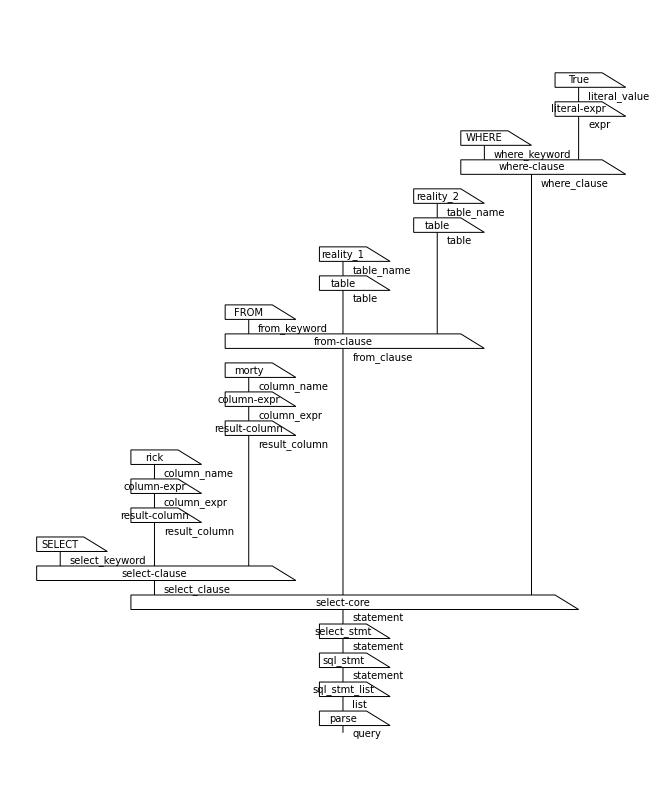

In [2]:
this_folder = os.path.abspath(os.getcwd())
walker = ParseTreeWalker()
listener = SQLiteParserListener(parser)
walker.walk(listener, tree)
diagram = listener.get_final_diagram().dagger()
width = diagram.width()
height = diagram.depth()
larger = max(width, height)
diagram.draw(figsize=(larger, larger + 2)) #path = this_folder + "\\figures\\figure.png")

The following code generates diagrams for all the SELECT-FROM-WHERE queries in the join order benchmark. Running the code will take some time and it works as a test package for the code. The diagrams are already generated in the folder `join-order-benchmark-diagrams`. The parameter `figsize` should be adjusted based on the length of the query but currently is has constant dimensions. 

In [3]:
#join_order_queries = glob.glob(this_folder + "\\join-order-benchmark\\[0-9]*.sql")
#for query in join_order_queries:
#    base_name = Path(query).stem
#    try:
#        input_stream = FileStream(query)
#        lexer = SQLiteLexer(input_stream)
#        stream = CommonTokenStream(lexer)
#        parser = SQLiteParser(stream)
#        tree = parser.parse()
#        walker = ParseTreeWalker()
#        listener = SQLiteParserListener(parser)
#        walker.walk(listener, tree)
#        diagram = listener.get_final_diagram().dagger()
#        diagram.draw(figsize=(100, 100), path = this_folder + "\\join-order-benchmark-diagrams\\" + base_name + ".png")
#    except:
#        print("Query: ", base_name, " failed.")

## Map context free grammar representations to pregroup representations

Because the abstract syntax tree contains lots of unnecessary information for our purposes, we can functorially rewrite it. This functorial rewriting process is just something that we have developed especially for this work and it is open to discussion if there exists a more suitable rewrite mapping. Also, the parts `select_main`, `from_main` and `where_main` are especially designed for this work although they are visible in the SQLite railroad diagrams without any special name.

Functor simply describes how the boxes and types are mapped. In this rewriting process we want to simplify the abstract syntax tree.

In [4]:
from discopy.rigid import Diagram, Cup, Cap, Id
from discopy.grammar.pregroup import Word

functor_data = None
with open('rewriter_functor_data.json') as json_file:
    functor_data = json.load(json_file)
    
def count_boxes(diagram, box_name):
    i = []
    def fun(boxes, box_name, i):
        for box in boxes:
            if box.name == box_name:
                i.append(box_name)
    
    for elem in diagram:
        elem.fmap(lambda x : fun(x.boxes, box_name, i))
    return len(i)

num_of_result_columns = count_boxes(diagram, "result-column")
num_of_tables = count_boxes(diagram, "table")

In [5]:
def object_mapping(obj):
    dom_ty_name = obj.name
    dom_ty = Ty()
    if dom_ty_name in functor_data["object_function"].keys():
        for ty in functor_data["object_function"][dom_ty_name]:
            if "." in ty:
                ty = ty.split(".")
                if ty[1] == "l":
                    dom_ty = dom_ty @ Ty(ty[0]).l
                elif ty[1] == "r":
                    dom_ty = dom_ty @ Ty(ty[0]).r
            else:
                dom_ty = dom_ty @ Ty(ty)
    elif dom_ty_name == "select-keyword":
        dom_ty = dom_ty @ Ty('s')
        for i in range(num_of_result_columns):
            dom_ty = dom_ty @ Ty('n').l
    elif dom_ty_name == "from-keyword":
        dom_ty = dom_ty @ Ty('s').r @ Ty('s')
        for i in range(num_of_tables):
            dom_ty = dom_ty @ Ty('n').l
    else:
        cod_name = dom_name
    return dom_ty

In [6]:
def arrow_mapping(box):
    morphism_dom_name = box.name
    #print(morphism_dom_name)
    #print(box.dom)
    #print(box.cod)
    result = Id(Ty())
    if morphism_dom_name in functor_data["arrow_function"].keys():
        cup = False
        for i in range(len(functor_data["arrow_function"][morphism_dom_name])):
            box = functor_data["arrow_function"][morphism_dom_name][i]
            if box["box"] == "Id":
                if "." in box["type"]:
                    ty = box["type"].split(".")
                    if ty[1] == "l":
                        result = result @ Id(Ty(ty[0]).l)
                    elif ty[1] == "r":
                        result = result @ Id(Ty(ty[0]).r)
                else:
                    result = result @ Id(Ty(box["type"]))
            elif box["box"] == "Cup":
                if cup:
                    cup = False
                    continue
                else:
                    cup = True
                left, right = None, None
                
                if "." in box["type"]:
                    ty = box["type"].split(".")
                    if ty[1] == "l":
                        left = Ty(ty[0]).l
                    elif ty[1] == "r":
                        left = Ty(ty[0]).r
                else:
                    left = Ty(box["type"])
                    
                box = functor_data["arrow_function"][morphism_dom_name][i + 1]
                
                if "." in box["type"]:
                    ty = box["type"].split(".")
                    if ty[1] == "l":
                        right = Ty(ty[0]).l
                    elif ty[1] == "r":
                        right = Ty(ty[0]).r
                else:
                    right = Ty(box["type"])
                
                result = result @ Cap(left, right)
                
    elif morphism_dom_name == "select-clause":
        result = Id(Ty('s'))
        left = Ty()
        for i in range(num_of_result_columns):
            left = left @ Ty('n')
        result = result @ Diagram.caps(left.l, left)
    elif morphism_dom_name == "from-clause":
        result = Id(Ty('s').r) @ Id(Ty('s'))
        left = Ty()
        for i in range(num_of_tables):
            left = left @ Ty('n')
        result = result @ Diagram.caps(left.l, left)
    elif type(box.cod) == Ty:
        if box.dom == Ty('literal_value'):
            result = Box(morphism_dom_name, Ty('e'), Ty())
        elif box.dom == Ty('where_keyword'):
            result = Box(morphism_dom_name, Ty('s').r @ Ty('s') @ Ty('e').l, Ty())
        elif box.dom == Ty('select_keyword'):
            dom_ty = Ty('s')
            for i in range(num_of_result_columns):
                dom_ty = dom_ty @ Ty('n').l
            result = Box(morphism_dom_name, dom_ty, Ty())
        elif box.dom == Ty('from_keyword'):
            dom_ty = Ty('s').r @ Ty('s')
            for i in range(num_of_tables):
                dom_ty = dom_ty @ Ty('n').l
            result = Box(morphism_dom_name, dom_ty, Ty())
        else:
            result = Box(morphism_dom_name, Ty('n'), Ty())
    #result.draw()
    return result

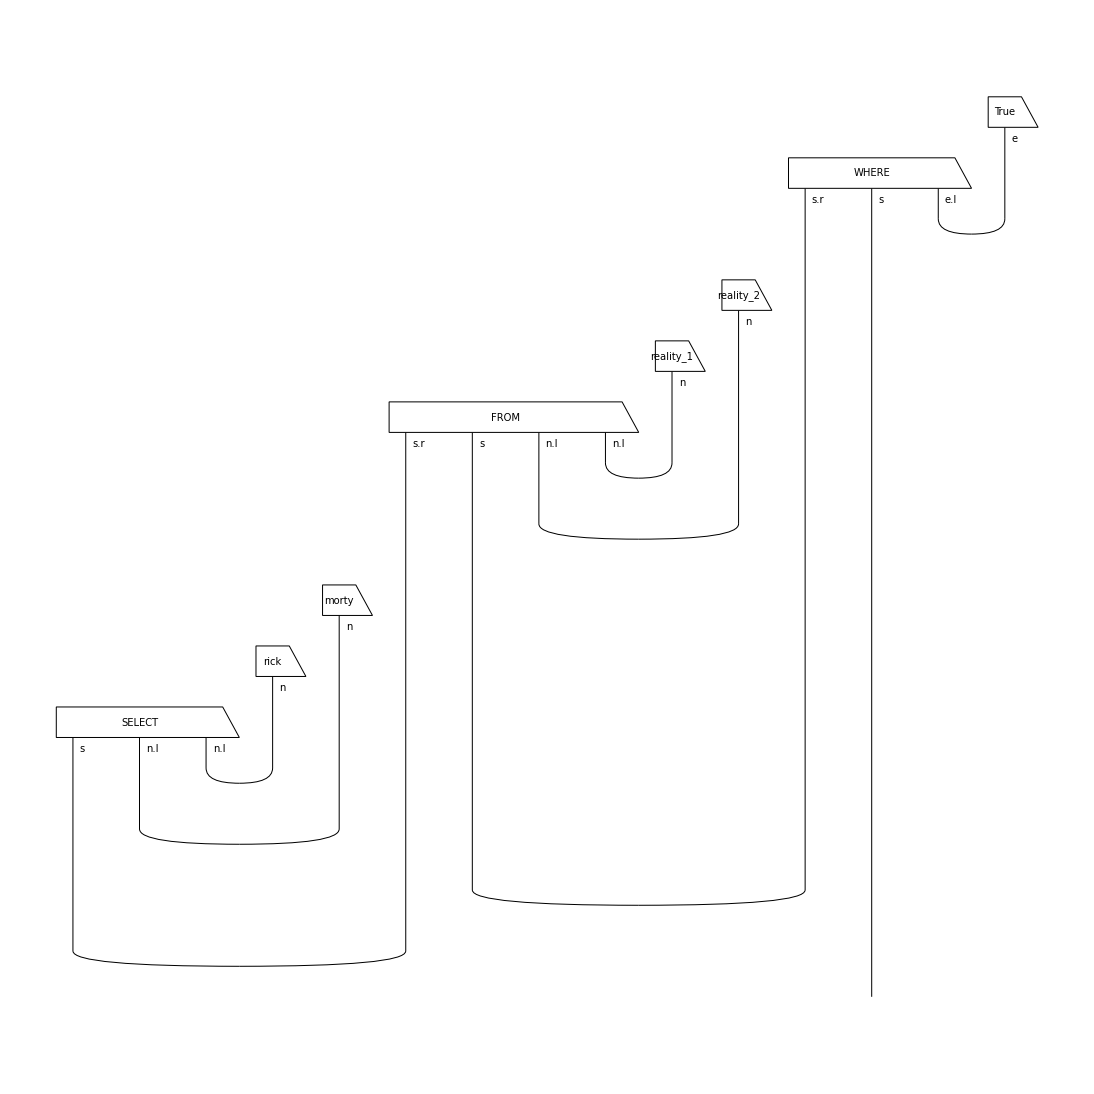

In [7]:
Rewriter = Functor(ob = lambda x: object_mapping(x), ar = lambda f: arrow_mapping(f))
pregroup_diagram = Rewriter(diagram)
pregroup_diagram.draw(figsize=(15, 15), path = this_folder + "\\figures\\pregroup_figure.png")

## Convert pregroup representations to circuits